In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

pm = "\u00B1"
MEDIUM_SIZE = 11
BIGGER_SIZE = 13

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize

base_font = {'family': 'serif',
        'size': MEDIUM_SIZE,
        }

title_font = {
  'fontsize' : BIGGER_SIZE, 
  'font' : 'serif', 
  'weight' : 'bold'
}

In [3]:
DATASETS = []
DATE = '2024-11-12'
directory = Path(DATE)

B_vals = (8, 10, 12, 14) # A
D_vals = (1036, 1039, 1042, 1045) # MHz

In [4]:
for B in B_vals:
  for D in D_vals:
    file_list = list(directory.glob(f"B={B}_D={D}_*.csv"))
    df = pd.read_csv(file_list[0])
    DATASETS.append(df)

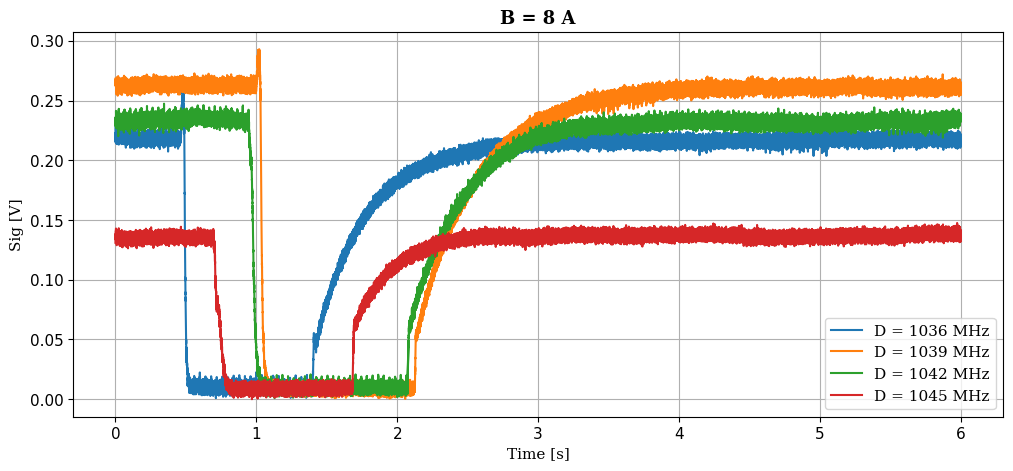

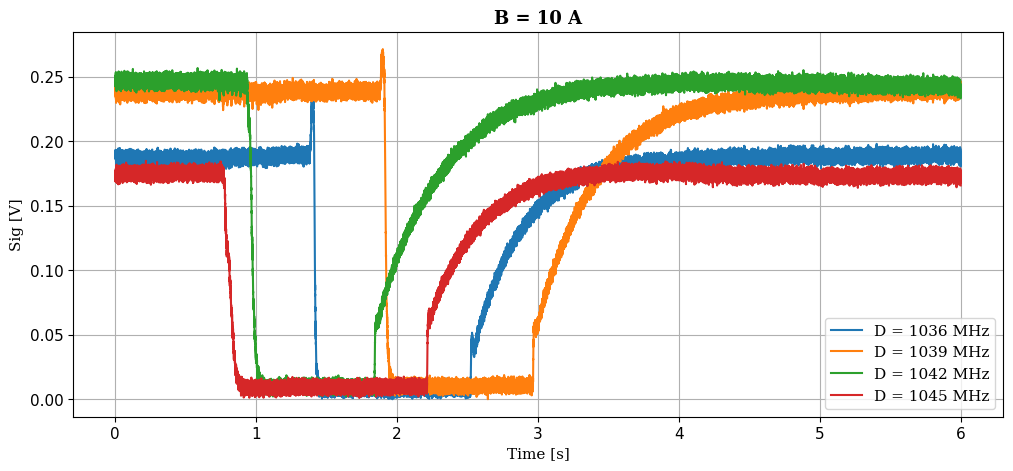

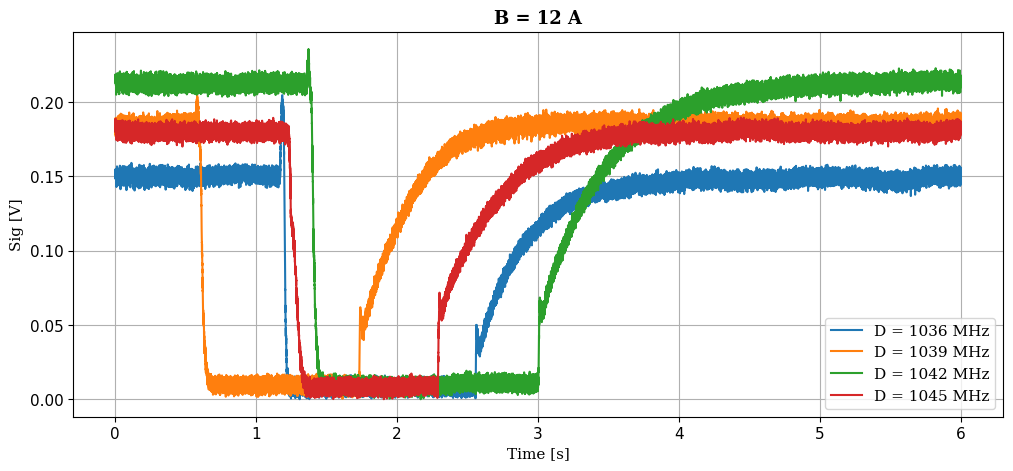

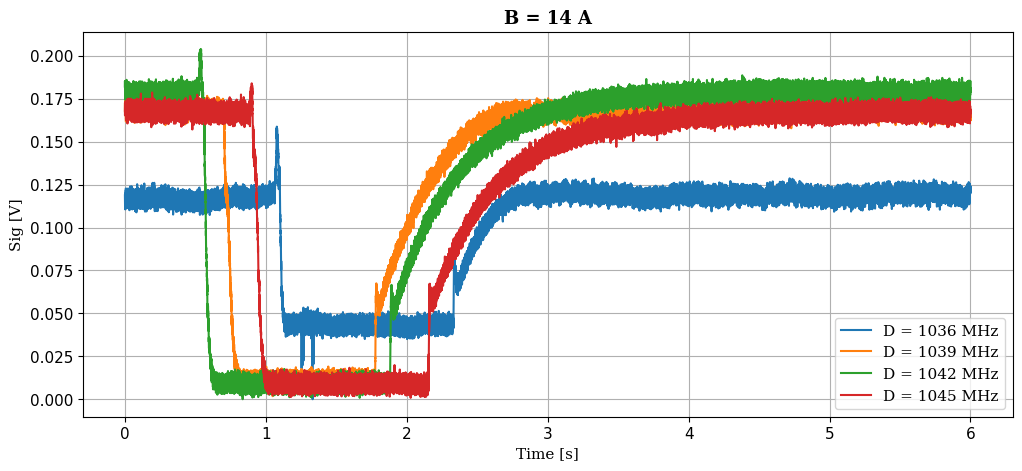

In [5]:
i = 0
for B in B_vals:
  _, ax = plt.subplots(1, 1, figsize=(12, 5))
  ax.set_title(f'B = {B} A', fontdict=title_font)
  for D in D_vals:
    df = DATASETS[i]
    i += 1
    x_data = df['Time [s]'].to_numpy()
    y_data = df['Sig [V]'].to_numpy()
    y_data = y_data - np.min(y_data)
    
    N = len(x_data)
    ax.plot(x_data[:N//2], y_data[:N//2], label=f'D = {D} MHz')
    ax.set_xlabel('Time [s]', fontdict=base_font)
    ax.set_ylabel('Sig [V]', fontdict=base_font)
  
  plt.legend(prop=base_font)
  plt.grid()
  plt.show()
    

In [6]:
from scipy.optimize import curve_fit

COOLER_MOT_FREQ = 1042# MHz
COOLER_RES_FREQ = 1027# MHz
GAMMA = 5.88 # MHz

DEFAULT_VOLTAGE_RANGE = 0.5 # V
DEFAULT_TIME_RANGE = 10 # s

def charge_MOT(t, V0, tau, off):
    return off + V0 * (1 - np.exp(-t/tau))
 
def fit_data(df, start_time_fit, end_time_fit):
  """Fit the data from the oscilloscope with an exponential and plot the result."""
  x_data = df['Time [s]']
  y_data = df['Sig [V]']
  
  # Select data for fitting based on start time
  index_fit = (x_data > start_time_fit) * (x_data < end_time_fit)
  x_data_fit = x_data[index_fit] - start_time_fit
  y_data_fit = y_data[index_fit]
  
  # Define initial parameter guesses
  sat_guess = np.mean(y_data_fit)
  tau_guess = 2  # s
  offset_guess = np.min(y_data_fit)  # Set offset close to minimum value
  
  # Perform curve fitting with initial guesses
  p0 = [sat_guess, tau_guess, offset_guess]
  popt, pcov = curve_fit(charge_MOT, x_data_fit, y_data_fit, p0=p0)
  V0, tau, off = popt
  dV0, dtau, doff = np.sqrt(np.diag(pcov))  # Uncertainties in fit parameters
  
  vc = V0 / tau # V / s
  dvc = (dV0/V0 + dtau/tau) * vc
  
  fit_errors = np.sqrt(np.diag(pcov))
  
  print(f'\n V0 = ({V0:.4f} {pm} {dV0:.4f}) V \n tau = ({tau:.4f} {pm} {dtau:.4f}) s \n offset = ({off:.4f} {pm} {doff:.4f}) V \n velocity capture = {vc:.4f} {pm} {dvc:.4f} V/s \n')
  
  # Generate fitted curve data
  x_fit = x_data_fit + start_time_fit  # Shift back to original time axis
  y_fit = charge_MOT(x_data_fit, *popt)
  
  _, ax = plt.subplots(1,1, figsize = (11, 5))
  ax.plot(x_data, y_data, label='Data', color='royalblue')
  ax.plot(x_fit, y_fit, label='Fit', color='crimson')
  ax.set_xlabel('Time [s]', fontdict=base_font)
  ax.set_ylabel('Sig [V]', fontdict=base_font)
  plt.grid()
  plt.legend()
  plt.show()
  
  return popt
  

# Generate Table with fit parameters for all the measurements

In [7]:
dict_params = {
  'V0 [V]': [],
  'tau [s]': [],
  'off [V]': [],
  'Vc [V/s]': []
}

## B = 8 A

---------------------------------------------------------------------

Magnetic Field = 8 A,   DETUNING = 1036 MHz

 V0 = (0.1784 ± 0.0001) V 
 tau = (0.3701 ± 0.0003) s 
 offset = (0.1795 ± 0.0001) V 
 velocity capture = 0.4819 ± 0.0007 V/s 



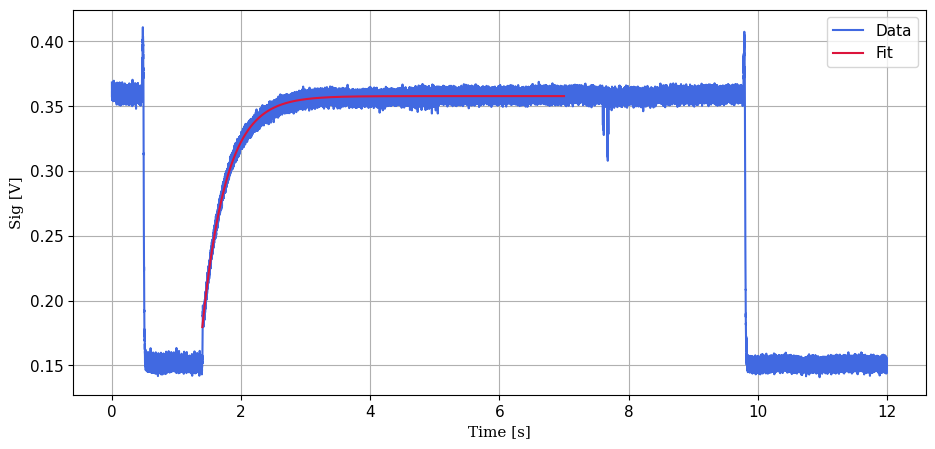

---------------------------------------------------------------------

Magnetic Field = 8 A,   DETUNING = 1039 MHz

 V0 = (0.1768 ± 0.0001) V 
 tau = (0.4425 ± 0.0004) s 
 offset = (0.2198 ± 0.0001) V 
 velocity capture = 0.3995 ± 0.0005 V/s 



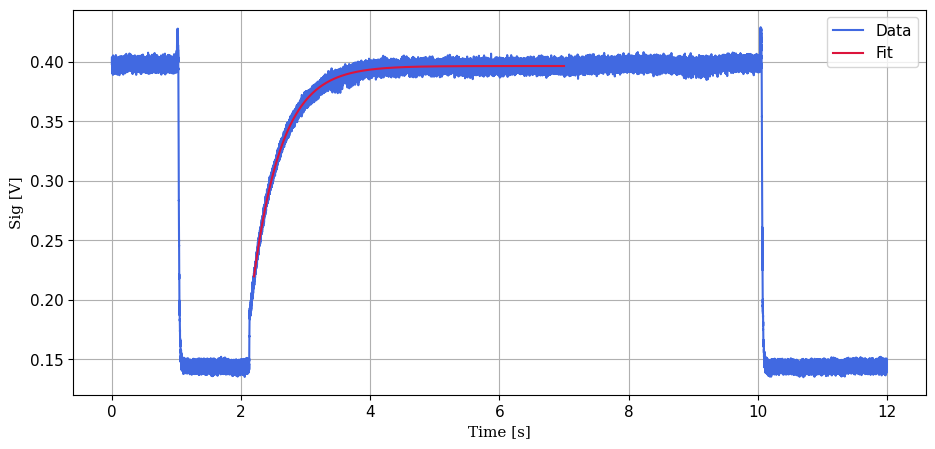

---------------------------------------------------------------------

Magnetic Field = 8 A,   DETUNING = 1042 MHz

 V0 = (0.1683 ± 0.0001) V 
 tau = (0.3698 ± 0.0004) s 
 offset = (0.1912 ± 0.0001) V 
 velocity capture = 0.4552 ± 0.0007 V/s 



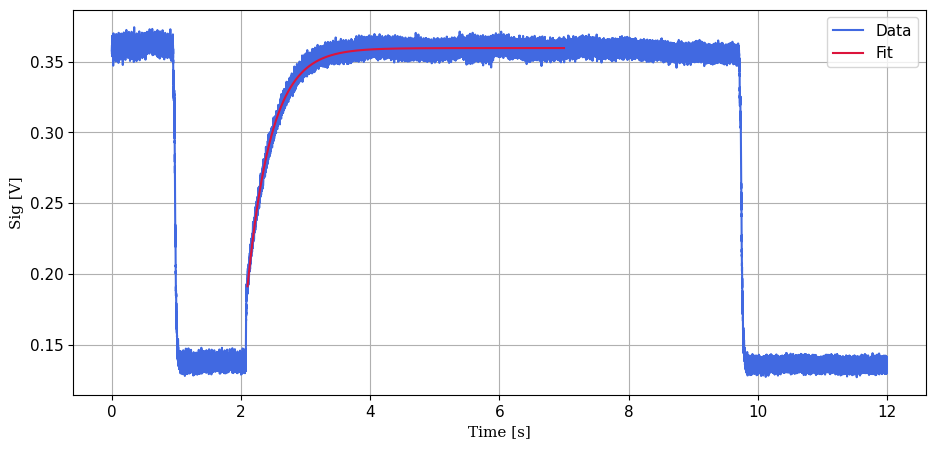

---------------------------------------------------------------------

Magnetic Field = 8 A,   DETUNING = 1045 MHz

 V0 = (0.0756 ± 0.0001) V 
 tau = (0.2651 ± 0.0006) s 
 offset = (0.1818 ± 0.0001) V 
 velocity capture = 0.2853 ± 0.0010 V/s 



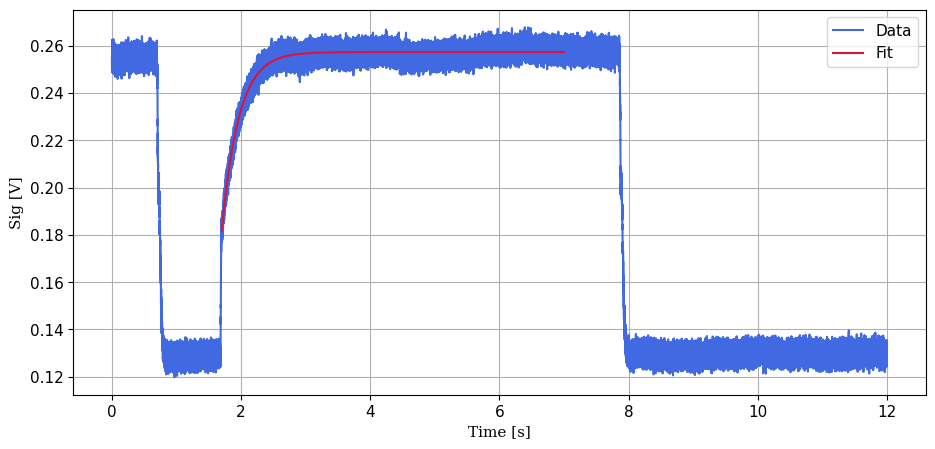

In [8]:
df_8_1036 = DATASETS[0]
df_8_1039 = DATASETS[1]
df_8_1042 = DATASETS[2]
df_8_1045 = DATASETS[3]

detunings = [1036, 1039, 1042, 1045]
DATA = [df_8_1036, df_8_1039, df_8_1042, df_8_1045]
initial_times = [1.4, 2.2, 2.1, 1.7]
end_times = [7, 7, 7, 7]

for i in range(4):
  det = detunings[i]
  print('---------------------------------------------------------------------')
  print(f'\nMagnetic Field = 8 A,   DETUNING = {det} MHz')
  V0, tau, off = fit_data(DATA[i], initial_times[i], end_times[i])
  dict_params['V0 [V]'].append(V0)
  dict_params['tau [s]'].append(tau)
  dict_params['Vc [V/s]'].append(V0/tau)
  dict_params['off [V]'].append(off)


---------------------------------------------------------------------

Magnetic Field = 10 A,   DETUNING = 1036 MHz

 V0 = (0.1269 ± 0.0001) V 
 tau = (0.3554 ± 0.0004) s 
 offset = (0.2043 ± 0.0001) V 
 velocity capture = 0.3571 ± 0.0007 V/s 



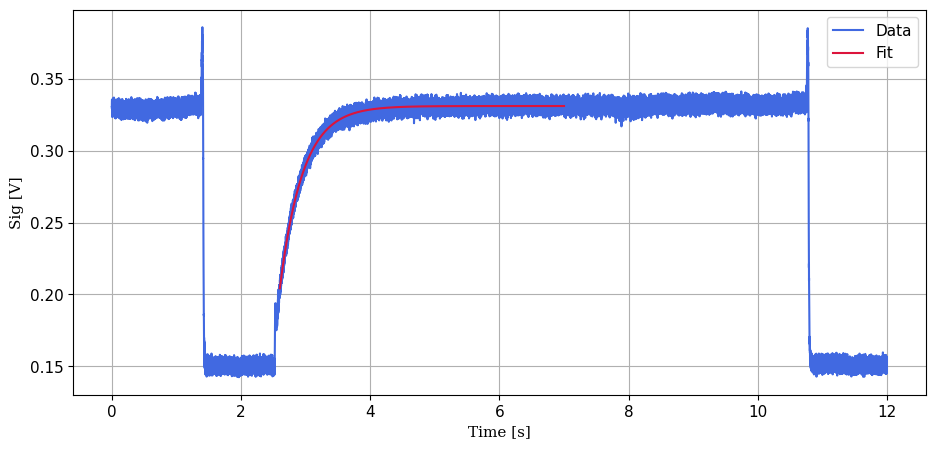

---------------------------------------------------------------------

Magnetic Field = 10 A,   DETUNING = 1039 MHz

 V0 = (0.1781 ± 0.0001) V 
 tau = (0.4334 ± 0.0004) s 
 offset = (0.1947 ± 0.0001) V 
 velocity capture = 0.4109 ± 0.0005 V/s 



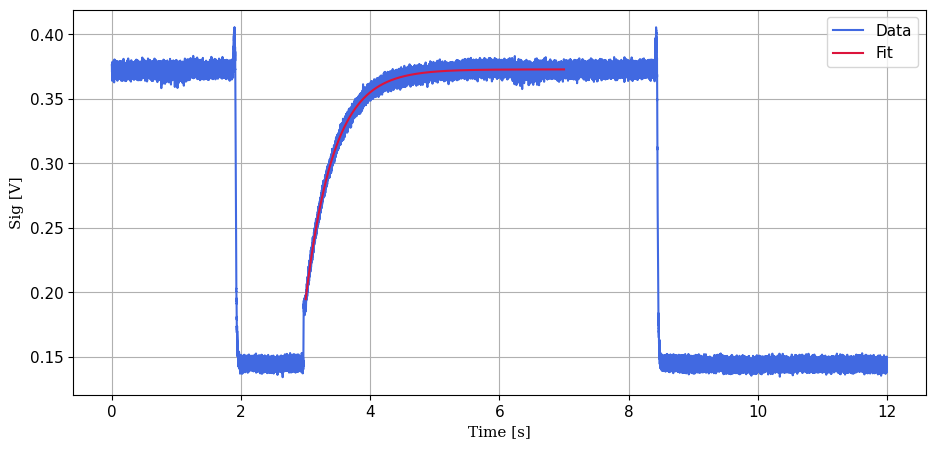

---------------------------------------------------------------------

Magnetic Field = 10 A,   DETUNING = 1042 MHz

 V0 = (0.1710 ± 0.0001) V 
 tau = (0.4448 ± 0.0004) s 
 offset = (0.2023 ± 0.0001) V 
 velocity capture = 0.3843 ± 0.0006 V/s 



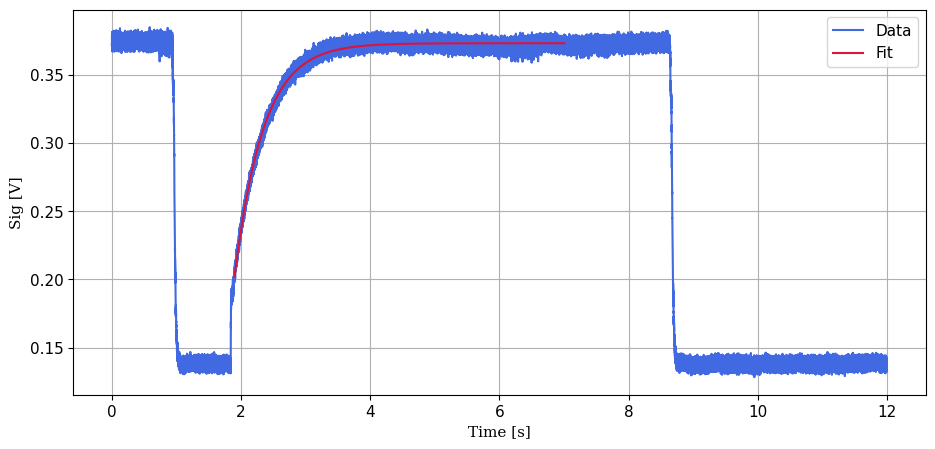

---------------------------------------------------------------------

Magnetic Field = 10 A,   DETUNING = 1045 MHz

 V0 = (0.1341 ± 0.0001) V 
 tau = (0.3024 ± 0.0005) s 
 offset = (0.1626 ± 0.0001) V 
 velocity capture = 0.4434 ± 0.0011 V/s 



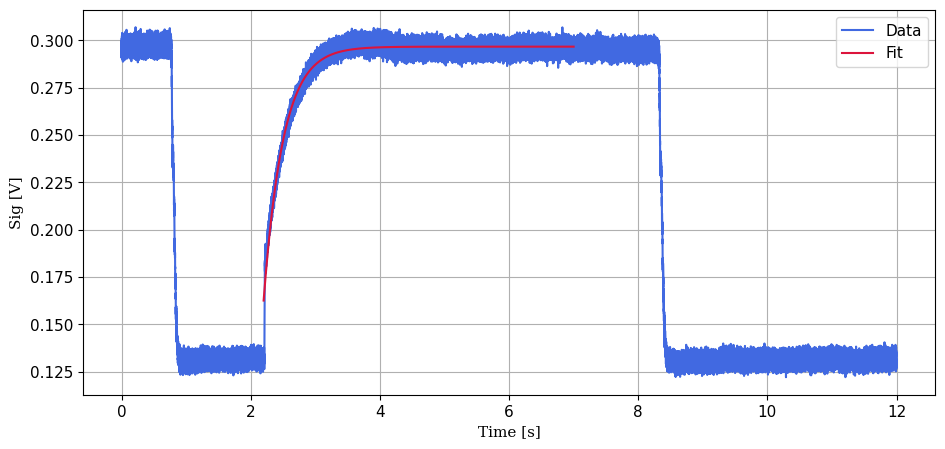

In [9]:
df_10_1036 = DATASETS[4]
df_10_1039 = DATASETS[5]
df_10_1042 = DATASETS[6]
df_10_1045 = DATASETS[7]

detunings = [1036, 1039, 1042, 1045]
DATA = [df_10_1036, df_10_1039, df_10_1042, df_10_1045]
initial_times = [2.6, 3, 1.9, 2.2]
end_times = [7, 7, 7, 7]

for i in range(4):
  det = detunings[i]
  print('---------------------------------------------------------------------')
  print(f'\nMagnetic Field = 10 A,   DETUNING = {det} MHz')
  V0, tau, off = fit_data(DATA[i], initial_times[i], end_times[i])
  dict_params['V0 [V]'].append(V0)
  dict_params['tau [s]'].append(tau)
  dict_params['Vc [V/s]'].append(V0/tau)
  dict_params['off [V]'].append(off)

---------------------------------------------------------------------

Magnetic Field = 12 A,   DETUNING = 1036 MHz

 V0 = (0.1076 ± 0.0001) V 
 tau = (0.3377 ± 0.0005) s 
 offset = (0.1880 ± 0.0001) V 
 velocity capture = 0.3185 ± 0.0008 V/s 



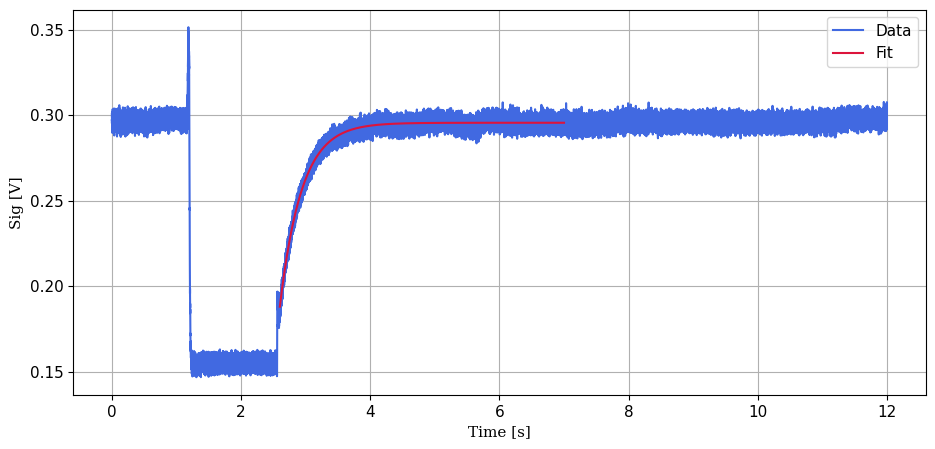

---------------------------------------------------------------------

Magnetic Field = 12 A,   DETUNING = 1039 MHz

 V0 = (0.1297 ± 0.0001) V 
 tau = (0.3097 ± 0.0004) s 
 offset = (0.1936 ± 0.0001) V 
 velocity capture = 0.4190 ± 0.0009 V/s 



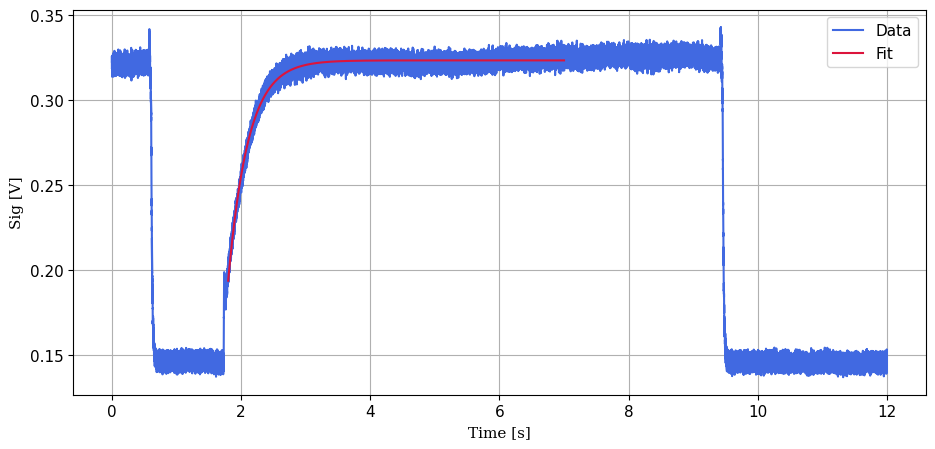

---------------------------------------------------------------------

Magnetic Field = 12 A,   DETUNING = 1042 MHz

 V0 = (0.1310 ± 0.0001) V 
 tau = (0.4686 ± 0.0005) s 
 offset = (0.2137 ± 0.0001) V 
 velocity capture = 0.2796 ± 0.0005 V/s 



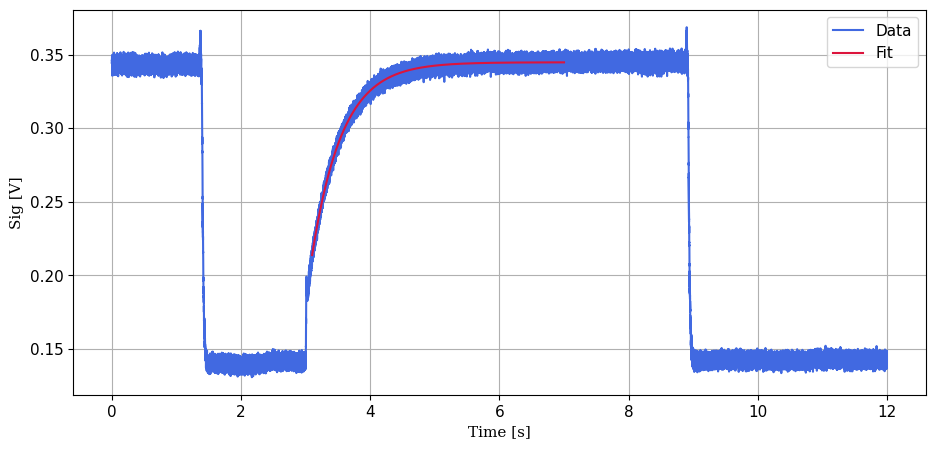

---------------------------------------------------------------------

Magnetic Field = 12 A,   DETUNING = 1045 MHz

 V0 = (0.1016 ± 0.0001) V 
 tau = (0.3822 ± 0.0006) s 
 offset = (0.2026 ± 0.0001) V 
 velocity capture = 0.2659 ± 0.0006 V/s 



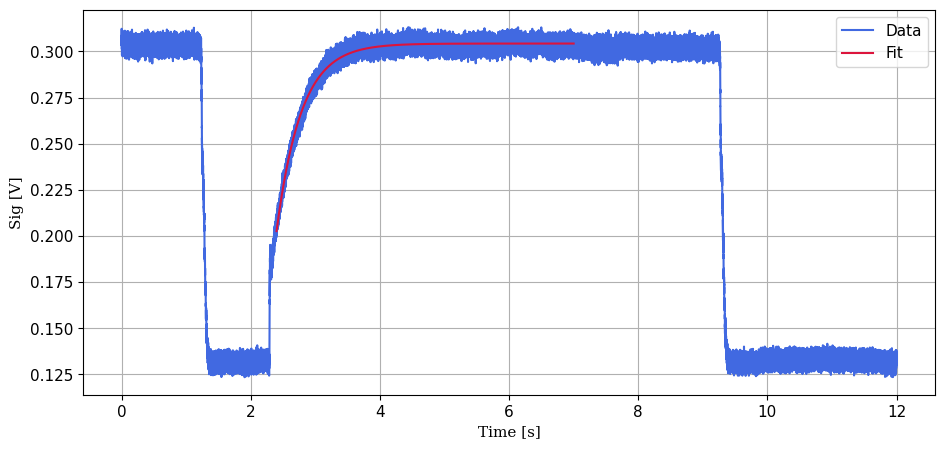

In [10]:
df_12_1036 = DATASETS[8]
df_12_1039 = DATASETS[9]
df_12_1042 = DATASETS[10]
df_12_1045 = DATASETS[11]

detunings = [1036, 1039, 1042, 1045]
DATA = [df_12_1036, df_12_1039, df_12_1042, df_12_1045]
initial_times = [2.6, 1.8, 3.1, 2.4]
end_times = [7, 7, 7, 7]

for i in range(4):
  det = detunings[i]
  print('---------------------------------------------------------------------')
  print(f'\nMagnetic Field = 12 A,   DETUNING = {det} MHz')
  V0, tau, off = fit_data(DATA[i], initial_times[i], end_times[i])
  dict_params['V0 [V]'].append(V0)
  dict_params['tau [s]'].append(tau)
  dict_params['Vc [V/s]'].append(V0/tau)
  dict_params['off [V]'].append(off)

---------------------------------------------------------------------

Magnetic Field = 14 A,   DETUNING = 1036 MHz

 V0 = (0.0483 ± 0.0002) V 
 tau = (0.1415 ± 0.0007) s 
 offset = (0.1803 ± 0.0002) V 
 velocity capture = 0.3412 ± 0.0027 V/s 



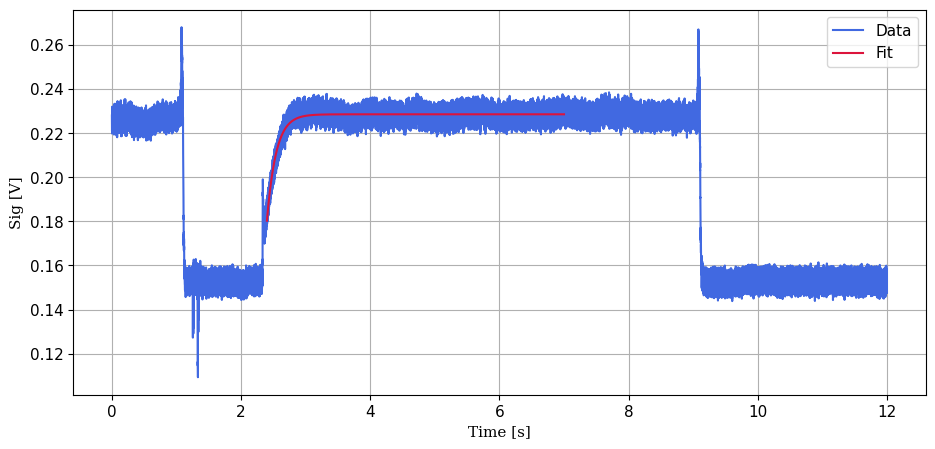

---------------------------------------------------------------------

Magnetic Field = 14 A,   DETUNING = 1039 MHz

 V0 = (0.1236 ± 0.0001) V 
 tau = (0.3137 ± 0.0004) s 
 offset = (0.1729 ± 0.0001) V 
 velocity capture = 0.3941 ± 0.0009 V/s 



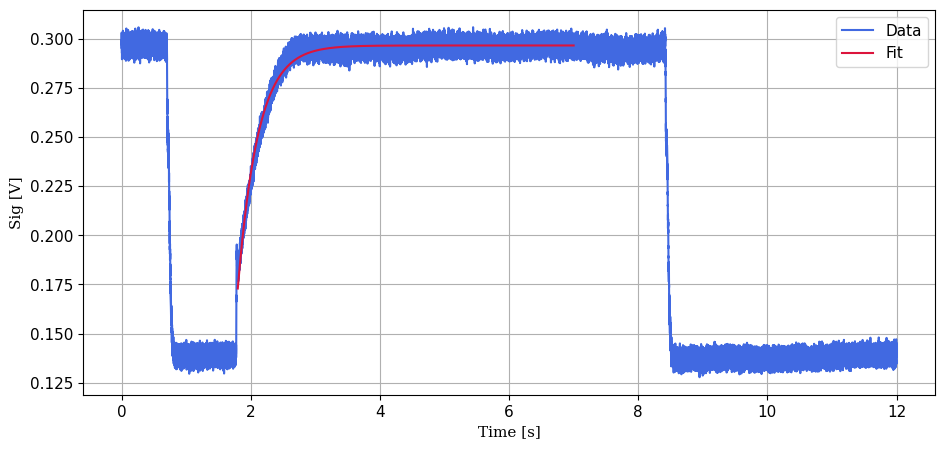

---------------------------------------------------------------------

Magnetic Field = 14 A,   DETUNING = 1042 MHz

 V0 = (0.1295 ± 0.0001) V 
 tau = (0.4615 ± 0.0005) s 
 offset = (0.1817 ± 0.0001) V 
 velocity capture = 0.2805 ± 0.0005 V/s 



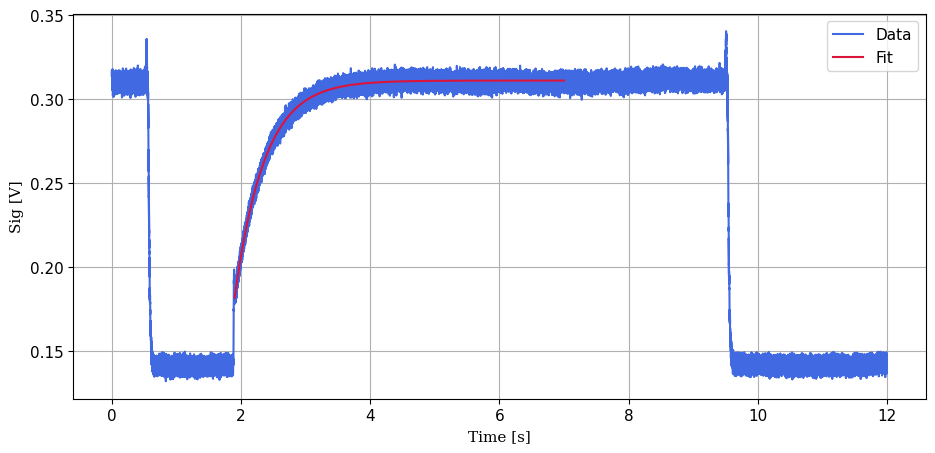

---------------------------------------------------------------------

Magnetic Field = 14 A,   DETUNING = 1045 MHz

 V0 = (0.1060 ± 0.0001) V 
 tau = (0.4917 ± 0.0006) s 
 offset = (0.1881 ± 0.0001) V 
 velocity capture = 0.2156 ± 0.0004 V/s 



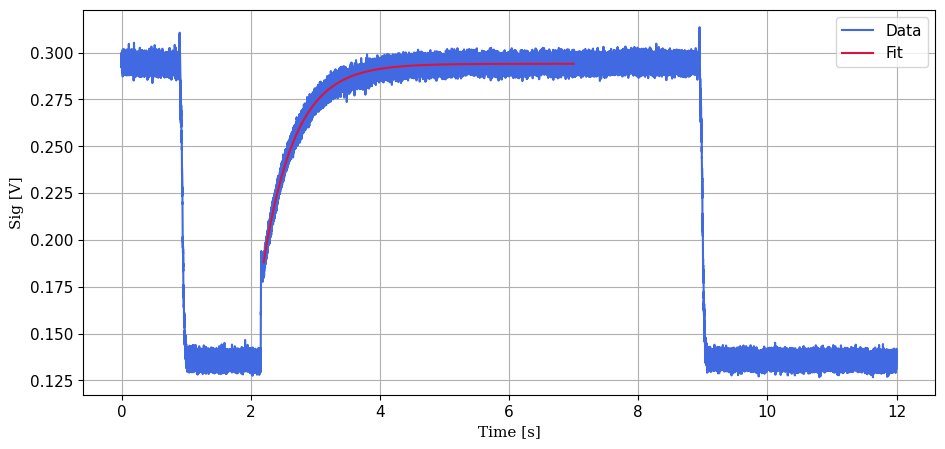

In [11]:
df_14_1036 = DATASETS[12]
df_14_1039 = DATASETS[13]
df_14_1042 = DATASETS[14]
df_14_1045 = DATASETS[15]

detunings = [1036, 1039, 1042, 1045]
DATA = [df_14_1036, df_14_1039, df_14_1042, df_14_1045]
initial_times = [2.4, 1.8, 1.9, 2.2]
end_times = [7, 7, 7, 7]

for i in range(4):
  det = detunings[i]
  print('---------------------------------------------------------------------')
  print(f'\nMagnetic Field = 14 A,   DETUNING = {det} MHz')
  V0, tau, off = fit_data(DATA[i], initial_times[i], end_times[i])
  dict_params['V0 [V]'].append(V0)
  dict_params['tau [s]'].append(tau)
  dict_params['Vc [V/s]'].append(V0/tau)
  dict_params['off [V]'].append(off)

In [41]:
index_names = []
for B in B_vals:
  for D in D_vals:
    index_names.append(f'B={B},D={D}')

params_df=pd.DataFrame(dict_params,index=index_names)
params_df

,V0 [V],tau [s],off [V],Vc [V/s]
"B=8,D=1036",0.178355,0.370085,0.179480,0.481929
"B=8,D=1039",0.176762,0.442471,0.219807,0.399490
"B=8,D=1042",0.168346,0.369840,0.191187,0.455187
"B=8,D=1045",0.075615,0.265064,0.181817,0.285270
"B=10,D=1036",0.126890,0.355374,0.204252,0.357060
"B=10,D=1039",0.178113,0.433448,0.194659,0.410921
"B=10,D=1042",0.170957,0.444822,0.202341,0.384326
"B=10,D=1045",0.134089,0.302386,0.162556,0.443435
"B=12,D=1036",0.107574,0.337747,0.187969,0.318506
"B=12,D=1039",0.129746,0.309668,0.193620,0.418985


In [42]:
color_palette = plt.cm.jet(np.linspace(0.68, 1, len(B_vals)))

## Plot V0 trend with D at different B

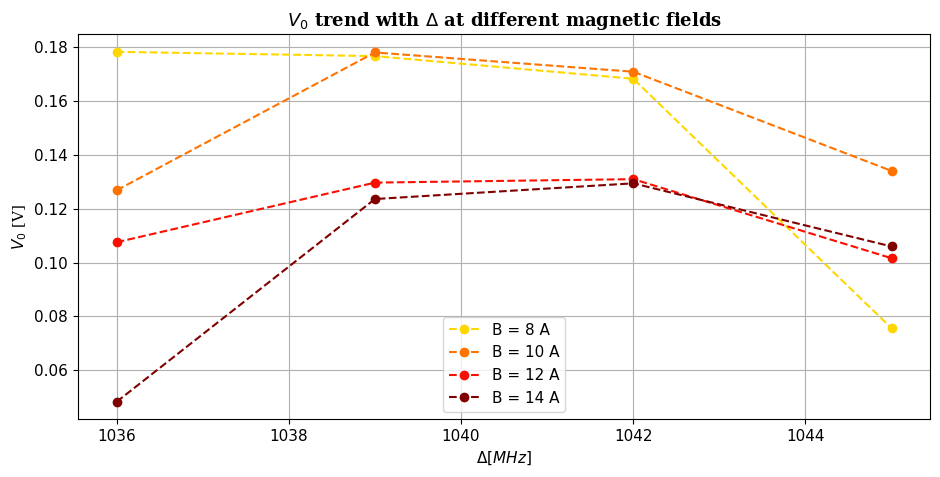

In [43]:
_, ax = plt.subplots(1,1, figsize = (11, 5))
ax.set_title(r'$V_0$ trend with $\Delta$ at different magnetic fields', fontdict=title_font)
for i, B in enumerate(B_vals):
  V0_vals = []
  for j, D in enumerate(D_vals):
    V0_vals.append(params_df['V0 [V]'][f'B={B},D={D}'])
  
  y_data = np.array(V0_vals)
  x_data = np.array(D_vals)
  ax.plot(x_data, y_data, '--o', label=f'B = {B} A', color=color_palette[i])
  ax.set_xlabel(r'$\Delta [MHz]$', fontdict=base_font)
  ax.set_ylabel(r'$V_0$ [V]', fontdict=base_font)

plt.legend()
plt.grid()
plt.show()

## Plot tau trend with D at different B

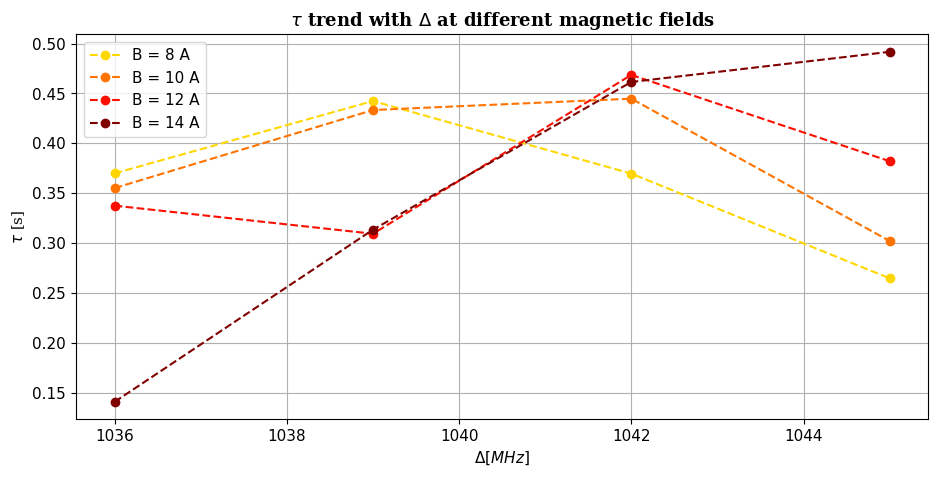

In [44]:
_, ax = plt.subplots(1,1, figsize = (11, 5))
ax.set_title(r'$\tau$ trend with $\Delta$ at different magnetic fields', fontdict=title_font)
for i, B in enumerate(B_vals):
  tau_vals = []
  for j, D in enumerate(D_vals):
    tau_vals.append(params_df['tau [s]'][f'B={B},D={D}'])
  
  y_data = np.array(tau_vals)
  x_data = np.array(D_vals)
  ax.plot(x_data, y_data, '--o', label=f'B = {B} A', color=color_palette[i])
  ax.set_xlabel(r'$\Delta [MHz]$', fontdict=base_font)
  ax.set_ylabel(r'$\tau$ [s]', fontdict=base_font)

plt.legend()
plt.grid()
plt.show()

## Plot Vc trend with D at different B

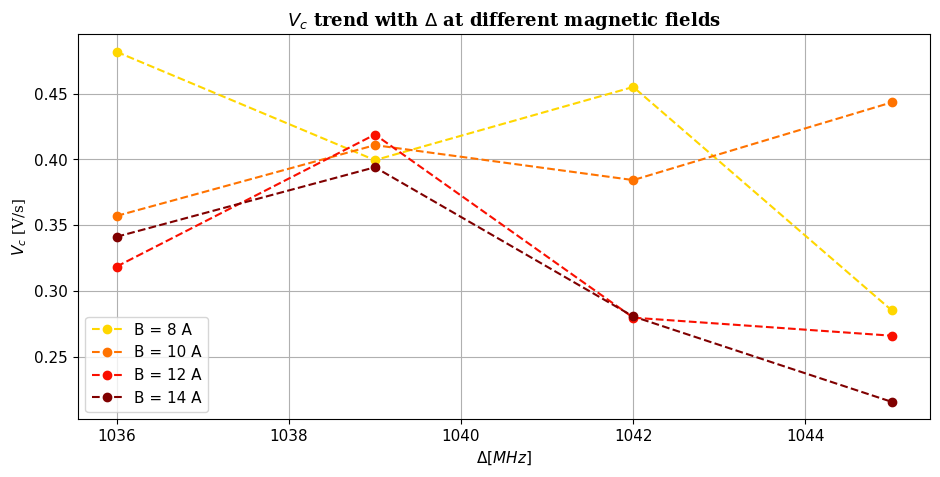

In [45]:
_, ax = plt.subplots(1,1, figsize = (11, 5))
ax.set_title(r'$V_c$ trend with $\Delta$ at different magnetic fields', fontdict=title_font)
for i, B in enumerate(B_vals):
  Vc_vals = []
  for j, D in enumerate(D_vals):
    Vc_vals.append(params_df['Vc [V/s]'][f'B={B},D={D}'])
  
  y_data = np.array(Vc_vals)
  x_data = np.array(D_vals)
  ax.plot(x_data, y_data, '--o', label=f'B = {B} A', color=color_palette[i])
  ax.set_xlabel(r'$\Delta [MHz]$', fontdict=base_font)
  ax.set_ylabel(r'$V_c$ [V/s]', fontdict=base_font)

plt.legend()
plt.grid()
plt.show()